<div style="font-size:2em; text-align:center; margin-top:30px; margin-bottom:20px">Smart Cities Project</div>
<hr>
<br>

<div style="font-size:4em; text-align:center; margin-bottom:30px; color:#00746E"><b>House Prediction Forecast</b></div>

In [1]:
# Load libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns  # data visualisation
import matplotlib.pyplot as plt  # data visualisation
%matplotlib inline
import datetime as dt  # working with time data
import plotly.graph_objs as go  # plotly graphical object
import plotly.express as px
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
import statsmodels.api as sm  # time-series analysis for python
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller Test (ADF Test) to check for stationarity
from statsmodels.tsa.api import VAR  # # Fitting the VAR model to the 2nd Differenced Data
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tools.eval_measures import rmse, aic
import warnings  
warnings.filterwarnings('ignore')
import missingno as msno
# from fbprophet import Prophet
# import geopandas as gpd
from sklearn.metrics import mean_squared_error  # MSE
from numpy import asarray as arr

# Allows to display all of the outputs of a cell
from IPython.display import display

# Set float data type format
pd.options.display.float_format = '{:,.2f}'.format

# Set the maximum number of row to be displayed
pd.options.display.max_rows = 999

# Set global visualisation settings
plt.rc('font', size=14)

In [2]:
# Load dataset
file_name = "./Smart_Cities/data/housing_in_london_monthly_variables.csv"
data = pd.read_csv(file_name, parse_dates = ['date'])
# df[:10]
print ('This dataset contains {} rows and {} columns.'.format(data.shape[0], data.shape[1]))
data.head()

This dataset contains 13549 rows and 7 columns.


date            area  average_price       code  houses_sold  \
0 1995-01-01  city of london          91449  E09000001        17.00   
1 1995-02-01  city of london          82203  E09000001         7.00   
2 1995-03-01  city of london          79121  E09000001        14.00   
3 1995-04-01  city of london          77101  E09000001         7.00   
4 1995-05-01  city of london          84409  E09000001        10.00   

   no_of_crimes  borough_flag  
0           nan             1  
1           nan             1  
2           nan             1  
3           nan             1  
4           nan             1

In [16]:
options = ['city of london', 'north east', 'england', 'westminster', 'lambeth', 'croydon', 'wandsworth', 
           'chelsea', 'kensington', 'camden', 'hammersmith', 'fulham'] 
    
# selecting rows based on condition
# df = data.loc[data['area'].isin(options)]
df = data.loc[
    (data['houses_sold'] <= 272) &
              (data['no_of_crimes'] >= 1640) &
#               (data['no_of_crimes'] <= 2356) &
              data['area'].isin(options)
             ]
    
print('\nResult dataframe :\n', df)
print ('This dataset contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))


Result dataframe :
            date         area  average_price       code  houses_sold  \
1879 2001-02-01       camden         267786  E09000007       210.00   
1880 2001-03-01       camden         273059  E09000007       263.00   
1881 2001-04-01       camden         268947  E09000007       267.00   
1889 2001-12-01       camden         291559  E09000007       271.00   
1890 2002-01-01       camden         290461  E09000007       237.00   
1891 2002-02-01       camden         289270  E09000007       243.00   
1902 2003-01-01       camden         322511  E09000007       265.00   
1903 2003-02-01       camden         306183  E09000007       205.00   
1904 2003-03-01       camden         299760  E09000007       235.00   
1905 2003-04-01       camden         306134  E09000007       198.00   
1906 2003-05-01       camden         321380  E09000007       203.00   
1907 2003-06-01       camden         327338  E09000007       250.00   
1913 2003-12-01       camden         323782  E09000007  

# Data Preprocess

average_price  houses_sold  no_of_crimes  borough_flag
count       2,107.00     2,093.00      1,027.00      2,107.00
mean      292,710.11    11,778.94      2,964.74          0.71
std       227,648.74    27,967.09      1,595.23          0.45
min        40,722.00         2.00          0.00          0.00
25%       124,443.50       296.00      2,245.00          0.00
50%       218,500.00       490.00      2,746.00          1.00
75%       382,116.00     2,579.00      3,774.50          1.00
max     1,117,408.00   132,163.00      7,461.00          1.00

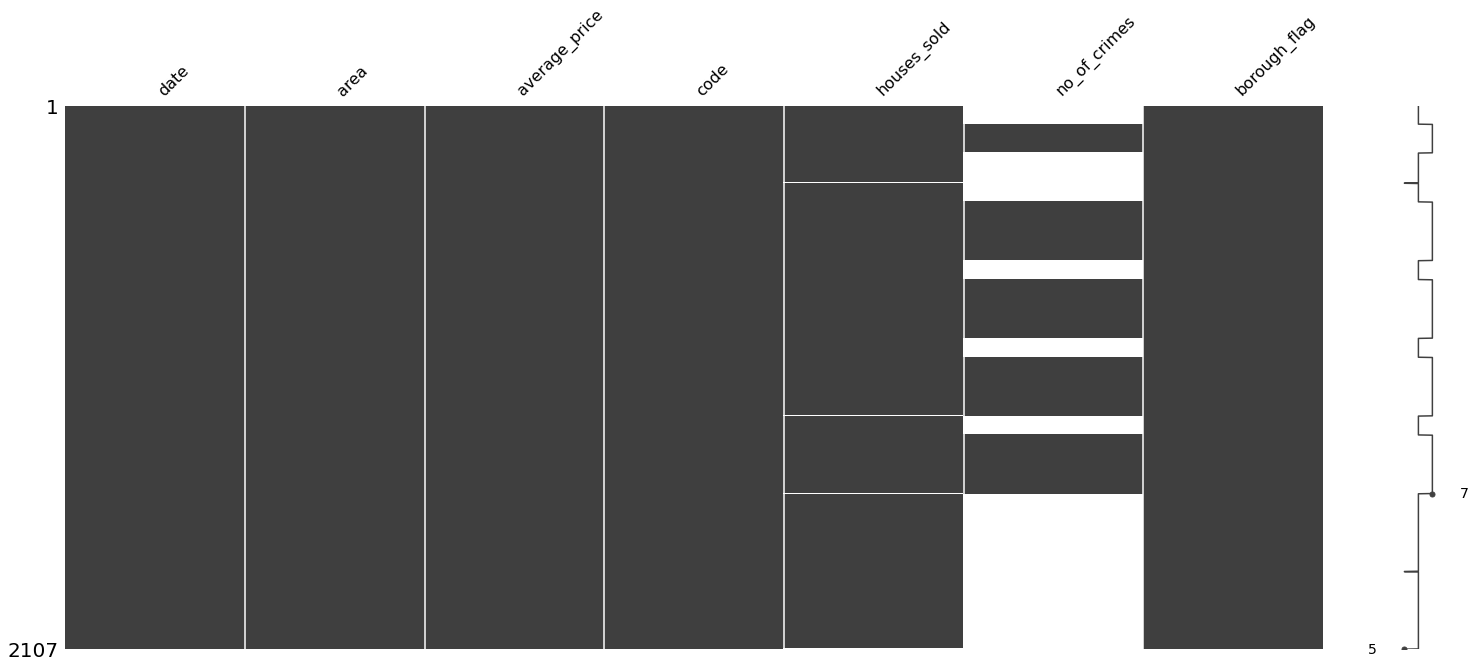

In [4]:
display(df.describe());

msno.matrix(df);

Observations:
* Yearly data is missing a few **'houses_sold'** values 
* Many values are missing for the **'no_of_crimes'** variable

In [5]:
# Set date as index for easier manipulation
df = df.set_index(pd.to_datetime(df['date']))

del df['date']

# Create dataset cuts
prices_london = df[df['borough_flag'] == 1]
prices_england = df[df['area'] == 'england']
prices_north_east = df[df['area'] == 'north east']

# Calculate mean prices for the different cuts of data
london_mean_price = prices_london.groupby('date')['average_price'].mean()
england_mean_price = prices_england.groupby('date')['average_price'].mean()
north_east_mean_price = prices_north_east.groupby('date')['average_price'].mean()

print('Processing Complete')

Processing Complete


# Data Exploration

In [6]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=london_mean_price.index, 
                         y=london_mean_price.values,
                         mode='lines',
                         name='London Mean House Price',
                        ))

fig.add_trace(go.Scatter(x=england_mean_price.index, 
                         y=england_mean_price.values,
                         mode='lines',
                         name='England Mean House Price',
                        ))

fig.add_trace(go.Scatter(x=north_east_mean_price.index, 
                         y=north_east_mean_price.values,
                         mode='lines',
                         name='North East Mean House Price',
                        ))


fig.update_layout(
    template='gridon',
    title='Average Monthly House Price',
    xaxis_title='Year',
    yaxis_title='Price (£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    legend=dict(y=-.2, orientation='h'),
    shapes=[
        dict(
            type="line",
            x0='2016-06-01',
            x1='2016-06-01',
            y0=0,
            y1=london_mean_price.values.max()*1.2,
            line=dict(
            color="LightSalmon",
            dash="dashdot"
            )
        ),
        dict(
            type="rect",
            x0="2007-12-01",
            y0=0,
            x1="2009-06-01",
            y1=london_mean_price.values.max()*1.2,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        ),
        dict(
            type="rect",
            x0="2001-03-01",
            y0=0,
            x1="2001-11-01",
            y1=london_mean_price.values.max()*1.2,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    ],
    annotations=[
            dict(text="The Great Recession", x='2007-12-01', y=london_mean_price.values.max()*1.2),
            dict(text="Brexit Vote", x='2016-06-01', y=london_mean_price.values.max()*1.2),
            dict(text="Dot-Com Bubble Recession", x='2001-03-01', y=london_mean_price.values.max()*1.2)
    ]
)

fig.show()

London's house prices are well above average when compared to England's. Furthermore, it dwarfs the prices of the relatively poor North East region.

It is clear that the global recession in 2008 has made a radical adjustment to the overall house prices, however, this was only temporary and London's house prices have rebounded since. The Brexit vote in 2016 has not impacted the prices in a significant way, but the price growth has plateaued.

As expected, the recession that followed the dot-com bubble had no material impact on UK's house prices. This is because this particular recession was mostly concentrated in the USA.

In [7]:
fig = px.line(prices_london, x=prices_london.index, y="average_price", color='area')

fig.update_layout(
    template='gridon',
    title='Average Monthly London House Price by Borough',
    xaxis_title='Year',
    yaxis_title='Price (£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

fig.show()

London has 33 boroughs (including City of London). Visually, this makes the exploration of the graph difficult. Luckily, Plotly allows to dynamically explore the data. You can click on area to hide it or double click to hide all other areas. Some key observations:
* Kensington and Chelsea historically has been and remains the most expensive borough to buy a house in
* The more expensive boroughs have greater volatility in average price
* Brent had a significant decline in house prices since 2019

In [17]:
# Set date as index for easier manipulation
df = df.set_index(pd.to_datetime(df['date']))

fig = px.line(df, x=df.index, y="average_price", color='area')

fig.update_layout(
    template='gridon',
    title='Average Monthly House Price by area',
    xaxis_title='Year',
    yaxis_title='Price (£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

fig.show()

In [8]:
# Calculate the mean yearly price per borough
yearly_prices_london = prices_london.groupby('area').resample('y')['average_price'].mean()

# Calculate the yealy average price percentage change
yearly_prices_london_pct_ch = yearly_prices_london.groupby(level='area').apply(lambda x: x.pct_change())

yearly_prices_london_pct_ch = yearly_prices_london_pct_ch.unstack()
yearly_prices_london_pct_ch = yearly_prices_london_pct_ch.iloc[::-1]

del yearly_prices_london_pct_ch['1995-12-31']

In [9]:
fig = go.Figure(data=go.Heatmap(
        z=yearly_prices_london_pct_ch.values,
        x=yearly_prices_london_pct_ch.columns,
        y=yearly_prices_london_pct_ch.index,
        colorscale='Cividis'))

fig.update_layout(
    title='YoY Average London House Price Percentage Change',
    title_x=0.5,
    yaxis_nticks=33,
    xaxis_title='Year',
    yaxis_title='Borough'
)

fig.show()

A heatmap provides an interesting way to analyze the changes in house prices. The year 2000 has seen the sharpest house price rise. The mid '10 have also seen the prices trending upwards, but they have been relatively stable / decreasing since. 

In [13]:
# # Load the shape file for mapping
# map_df = gpd.read_file('../input/london-borough-and-ward-boundaries-up-to-2014/London_Wards/Boroughs/London_Borough_Excluding_MHW.shp')

# map_df = map_df[['NAME', 'geometry']]
# map_df = map_df.rename(columns={'NAME': 'area'})
# map_df['area'] = map_df['area'].str.lower()
# map_df['area'] = map_df['area'].str.replace('&','and')

# yearly_prices_london_df_map = pd.DataFrame(yearly_prices_london)
# yearly_prices_london_df_map = yearly_prices_london_df_map.reset_index()

# price_map = map_df.set_index('area').join(yearly_prices_london_df_map.set_index('area'))
# price_map = price_map.reset_index()

# price_map = price_map[price_map['date'] == '2019-12-31']

In [14]:
# variable = 'average_price'

# fig, ax = plt.subplots(1, figsize=(15, 10))
# price_map.plot(column=variable, 
#                cmap='Blues', 
#                linewidth=1, 
#                ax=ax, 
#                edgecolor='0.8', 
#                legend=True,
#                legend_kwds={'label': "Average House Price",
#                            'orientation': "horizontal"})
# ax.axis('off')
# plt.suptitle('Average London House Price by Borough Visualised')
# plt.show()

The map nicely illustrates that West London tends to be a much more expensive place to live than East London. 

---------------------------------------------------------------------------------------------------------------------------

In [26]:
df.head(5)

area  average_price       code  houses_sold  \
date                                                                
1995-01-01  city of london          91449  E09000001        17.00   
1995-02-01  city of london          82203  E09000001         7.00   
1995-03-01  city of london          79121  E09000001        14.00   
1995-04-01  city of london          77101  E09000001         7.00   
1995-05-01  city of london          84409  E09000001        10.00   

            no_of_crimes  borough_flag  
date                                    
1995-01-01           nan             1  
1995-02-01           nan             1  
1995-03-01           nan             1  
1995-04-01           nan             1  
1995-05-01           nan             1

In [27]:
df['no_of_crimes'] = df['no_of_crimes'].fillna(0)
df['houses_sold'] = df['houses_sold'].fillna(0)

In [28]:
df_london = df[(df['area'] == 'lambeth')]
df_london.head(5)

area  average_price       code  houses_sold  no_of_crimes  \
date                                                                       
1995-01-01  lambeth          67771  E09000022       227.00          0.00   
1995-02-01  lambeth          65382  E09000022       207.00          0.00   
1995-03-01  lambeth          66337  E09000022       315.00          0.00   
1995-04-01  lambeth          66389  E09000022       288.00          0.00   
1995-05-01  lambeth          69035  E09000022       309.00          0.00   

            borough_flag  
date                      
1995-01-01             1  
1995-02-01             1  
1995-03-01             1  
1995-04-01             1  
1995-05-01             1

In [29]:
# Visualize the trends in data
# sns.set_style('darkgrid')
# df.plot(kind = 'line', legend = 'reverse', title = 'Visualizing Multivariate Time-Series')
# plt.legend(loc = 'upper right', shadow = True, bbox_to_anchor = (1.35, 0.8))
# plt.show()

# Dropping area, code, & borough flag as they do not change with Time
# df_time_series = df.drop(['area', 'code', 'borough_flag'], axis = 1)  # inplace = True

# Again Visualizing the time-series data
sns.set_style('darkgrid')
df_london.plot(kind = 'line', legend = 'reverse', title = 'Visualizing Multivariate Time-Series')
# df_time_series.plot(kind = 'line', legend = 'reverse', title = 'Visualizing Multivariate Time-Series')
plt.legend(loc = 'upper right', shadow = True, bbox_to_anchor = (1.35, 0.8))
plt.show()

In [30]:
# Splitting the dataset into train & test subsets
n_obs = 100
df_train, df_test = df[:-n_obs], df[-n_obs:]

def adf_test(df):
    dftest = adfuller(df, autolag='AIC')
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])

    for key, value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']
    if p <= 0.05:
        print("\nSeries is Stationary")
    else:
        print("\nSeries is Non-Stationary")


for i in df_train.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_train[i])
    print('\n')

# Differencing all variables to get rid of Stationarity
df_differenced = df_train.diff().dropna()

# Running the ADF test once again to test for Stationarity
for i in df_differenced.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_differenced[i])
    print('\n')

# Now cols: 3, 5, 6, 8 are non-stationary
df_differenced = df_differenced.diff().dropna()

# Running the ADF test for the 3rd time to test for Stationarity
for i in df_differenced.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_differenced[i])
    print('\n')

Column:  area
--------------------------------------


ValueError: could not convert string to float: 'city of london'

---------------------------------------------------------------------------------------------------------------------------

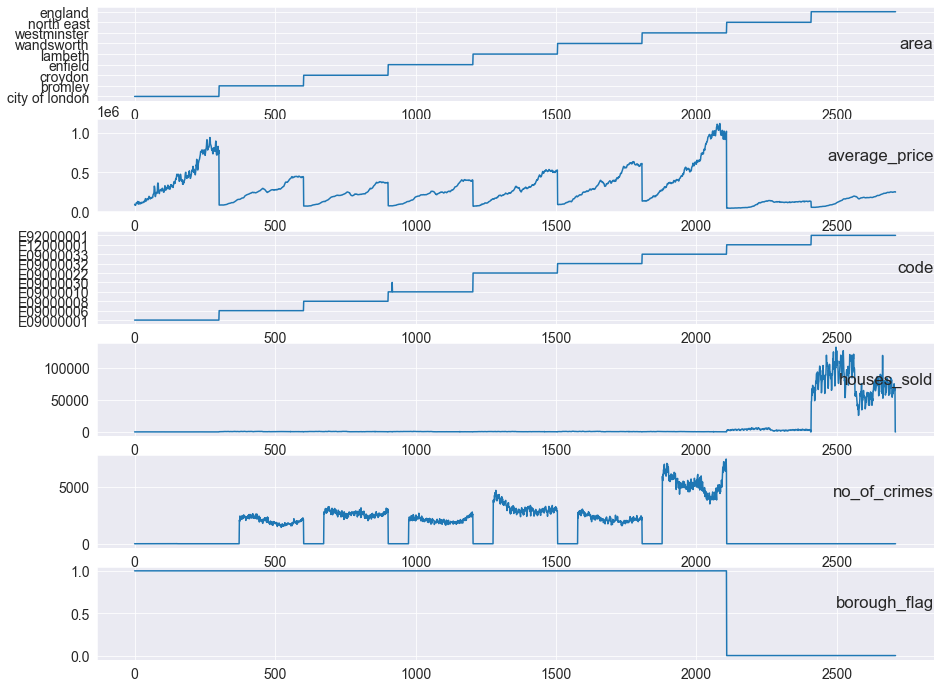

In [36]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

---------------------------------------------------------------------------------------------------------------------------

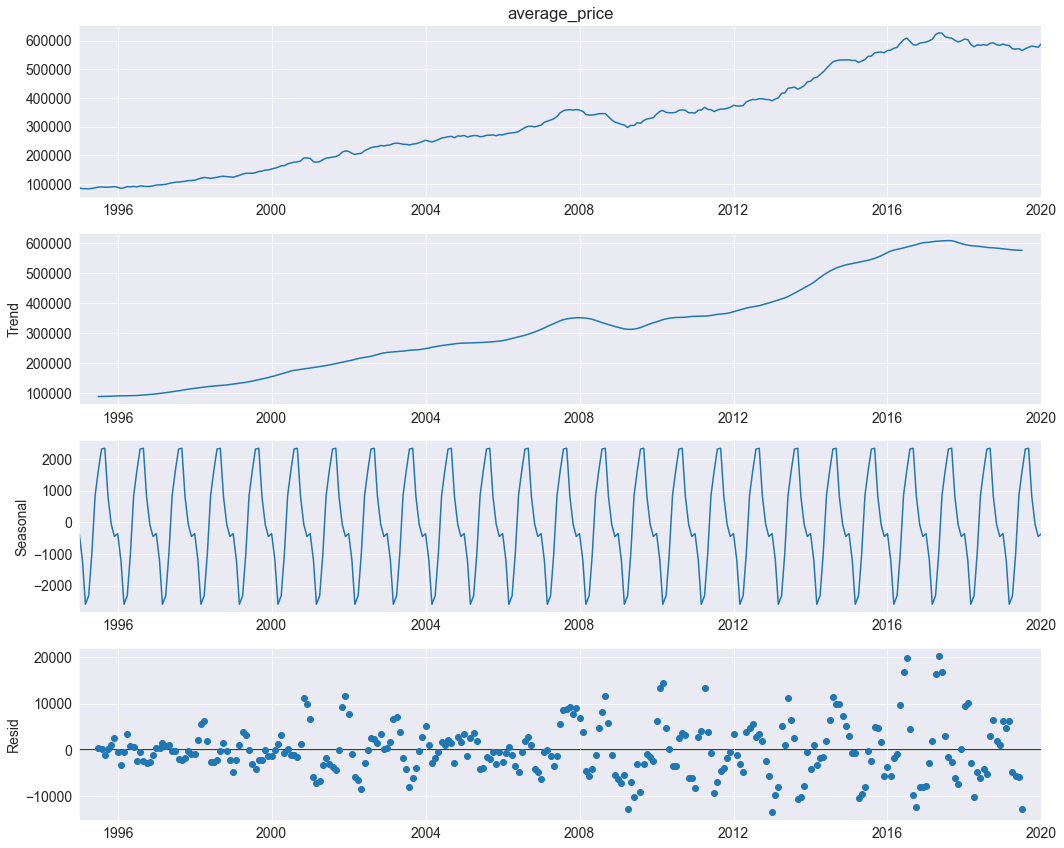

In [37]:
decomposition = sm.tsa.seasonal_decompose(london_mean_price, model='additive')
fig = decomposition.plot()
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

In [26]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [27]:
df.head()

average_price  houses_sold  no_of_crimes
date                                                
1995-01-01         120933       198.00          0.00
1995-02-01         119509       194.00          0.00
1995-03-01         120282       207.00          0.00
1995-04-01         120098       174.00          0.00
1995-05-01         119929       220.00          0.00

In [28]:
df.shape

(301, 3)

In [29]:
duplicate = df[df.duplicated('average_price')]
duplicate.shape

(0, 3)

In [30]:
# dropping ALL duplicate values
df.drop_duplicates(subset ="average_price", keep = False, inplace = True)

In [31]:
df.shape

(301, 3)

In [32]:
# Converting the time series data to long table format
wide_df = df.pivot(columns = 'average_price')
wide_df = wide_df.reset_index(level = ['date'])
wide_df

date houses_sold                                     \
average_price                 115419 117458 118739 119509 119560 119929   
0             1995-01-01         nan    nan    nan    nan    nan    nan   
1             1995-02-01         nan    nan    nan 194.00    nan    nan   
2             1995-03-01         nan    nan    nan    nan    nan    nan   
3             1995-04-01         nan    nan    nan    nan    nan    nan   
4             1995-05-01         nan    nan    nan    nan    nan 220.00   
5             1995-06-01         nan    nan    nan    nan    nan    nan   
6             1995-07-01         nan    nan    nan    nan    nan    nan   
7             1995-08-01         nan    nan    nan    nan    nan    nan   
8             1995-09-01         nan    nan    nan    nan    nan    nan   
9             1995-10-01         nan 245.00    nan    nan    nan    nan   
10            1995-11-01      208.00    nan    nan    nan    nan    nan   
11            1995-12-01         nan    nan 224.00    nan    nan    nan   
12            1996-01-01         nan    nan    nan    nan 193.00    nan   
13            1996-02-01         nan    nan    nan    nan    nan    nan   
14            1996-03-01         nan    nan    nan    nan    nan    nan   
15            1996-04-01         nan    nan    nan    nan    nan    nan   
16            1996-05-01         nan    nan    nan    nan    nan    nan   
17            1996-06-01         nan    nan    nan    nan    nan    nan   
18            1996-07-01         nan    nan    nan    nan    nan    nan   
19            1996-08-01         nan    nan    nan    nan    nan    nan   
20            1996-09-01         nan    nan    nan    nan    nan    nan   
21            1996-10-01         nan    nan    nan    nan    nan    nan   
22            1996-11-01         nan    nan    nan    nan    nan    nan   
23            1996-12-01         nan    nan    nan    nan    nan    nan   
24            1997-01-01         nan    nan    nan    nan    nan    nan   
25            1997-02-01         nan    nan    nan    nan    nan    nan   
26            1997-03-01         nan    nan    nan    nan    nan    nan   
27            1997-04-01         nan    nan    nan    nan    nan    nan   
28            1997-05-01         nan    nan    nan    nan    nan    nan   
29            1997-06-01         nan    nan    nan    nan    nan    nan   
30            1997-07-01         nan    nan    nan    nan    nan    nan   
31            1997-08-01         nan    nan    nan    nan    nan    nan   
32            1997-09-01         nan    nan    nan    nan    nan    nan   
33            1997-10-01         nan    nan    nan    nan    nan    nan   
34            1997-11-01         nan    nan    nan    nan    nan    nan   
35            1997-12-01         nan    nan    nan    nan    nan    nan   
36            1998-01-01         nan    nan    nan    nan    nan    nan   
37            1998-02-01         nan    nan    nan    nan    nan    nan   
38            1998-03-01         nan    nan    nan    nan    nan    nan   
39            1998-04-01         nan    nan    nan    nan    nan    nan   
40            1998-05-01         nan    nan    nan    nan    nan    nan   
41            1998-06-01         nan    nan    nan    nan    nan    nan   
42            1998-07-01         nan    nan    nan    nan    nan    nan   
43            1998-08-01         nan    nan    nan    nan    nan    nan   
44            1998-09-01         nan    nan    nan    nan    nan    nan   
45            1998-10-01         nan    nan    nan    nan    nan    nan   
46            1998-11-01         nan    nan    nan    nan    nan    nan   
47            1998-12-01         nan    nan    nan    nan    nan    nan   
48            1999-01-01         nan    nan    nan    nan    nan    nan   
49            1999-02-01         nan    nan    nan    nan    nan    nan   
50            1999-03-01         nan    nan    nan    nan    nan    nan   
51            1999-04-01         nan    nan  

In [34]:
# wide_df.columns = wide_df.columns.droplevel(0)
# wide_df
# wide_df.columns = ['date', 'average_price', 'houses_sold', 'no_of_crimes']
# wide_df.set_index('date', inplace = True)

In [58]:
# grangers_causation_matrix(wide_df, variables = wide_df.columns) 

If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row). In this case, the null hypothesis is significant (0.0), therefore we reject null hypothesis, and say that `sales of item1` causes `sales of item2`.
    
This makes this system of multi time series a good candidate for using VAR models to forecast.

Next, let’s do the Cointegration test.

In [35]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [37]:
# cointegration_test(wide_df)

In [83]:
nobs = 30
df_train, df_test = wide_df[0:-nobs], wide_df[-nobs:]

# Check size
print(df_train.shape)  # (1796, 2)
print(df_test.shape)  # (30, 2)

(271, 26287)
(30, 26287)


In [84]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [86]:
df['no_of_crimes'] = df['no_of_crimes'].fillna(0)
df['houses_sold'] = df['houses_sold'].fillna(0)

In [88]:
df.head()

average_price  houses_sold  no_of_crimes
date                                                
1995-01-01          91449        17.00          0.00
1995-02-01          82203         7.00          0.00
1995-03-01          79121        14.00          0.00
1995-04-01          77101         7.00          0.00
1995-05-01          84409        10.00          0.00

In [94]:
# # ADF Test on each column
# for name, column in df_train.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

In [89]:
# Perform 1st order differencing 
df_differenced = df_train.diff().dropna()

In [95]:
# # ADF Test on each column of 1st Differences Dataframe
# for name, column in df_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

In [96]:
# model = VAR(df_differenced)
# for i in list(range(1, 9)):
#     result = model.fit(i)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')

In [101]:
# x = model.select_order(maxlags=12)
# x.summary()

In [102]:
# model_fitted = model.fit(4)
# model_fitted.summary()

In [103]:
# from statsmodels.stats.stattools import durbin_watson
# out = durbin_watson(model_fitted.resid)

# for col, val in zip(buf.columns, out):
#     print(col, ':', round(val, 2))

In [98]:
# # Get the lag order
# lag_order = model_fitted.k_ar
# print(lag_order)  #> 4

In [97]:
# # Input data for forecasting
# forecast_input = df_differenced.values[-lag_order:]
# forecast_input

In [100]:
# # Forecast
# fc = model_fitted.forecast(y=forecast_input, steps=nobs)
# df_forecast = pd.DataFrame(fc, index=wide_df.index[-nobs:], columns=wide_df.columns + '_1d')
# df_forecast

In [99]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [104]:
# df_results = invert_transformation(df_train, df_forecast, second_diff=False)   
# df_results.loc[:, ['item1_forecast', 'item2_forecast']    ].round(2)

In [105]:
# df_results_f = df_results.loc[:, ['item1_forecast', 'item2_forecast']    ].round(2)
# df_results_f.set_index(df_test.index, inplace = True) 
# df_results_f.reset_index(inplace = True)
# df_results_f

In [106]:
# # Visualise time series
# df_results_long = pd.melt(df_results_f, id_vars = ["date"], value_vars = ['item1_forecast', 'item2_forecast'], var_name = 'item', value_name ='sales')
# df_results_long['item'] = df_results_long['item'].str.replace('_forecast', '')


In [107]:
# df_results_long.head()

In [108]:
# df_results_long['date'] = df_results_long.date.dt.strftime('%Y-%m-%d')

In [109]:
# import plotly.express as px
# fff = px.line(df_results_long, x = 'date', y = 'sales', color = 'item' )
# fff.update_layout(title = 'Forecasted sales for Item 1 and Item 2')
# fff.show()

# House Price Prediction

In [19]:
# # Prepare the 
# model_df = pd.DataFrame(london_mean_price).reset_index()
# model_df = model_df.rename(columns={'date': 'ds', 'average_price': 'y'})

# # Initialise the model and make predictions
# m = Prophet()
# m.fit(model_df)

# future = m.make_future_dataframe(periods=24, freq='M')

# forecast = m.predict(future)

# # Visualise the prediction
# fig1 = m.plot(forecast)

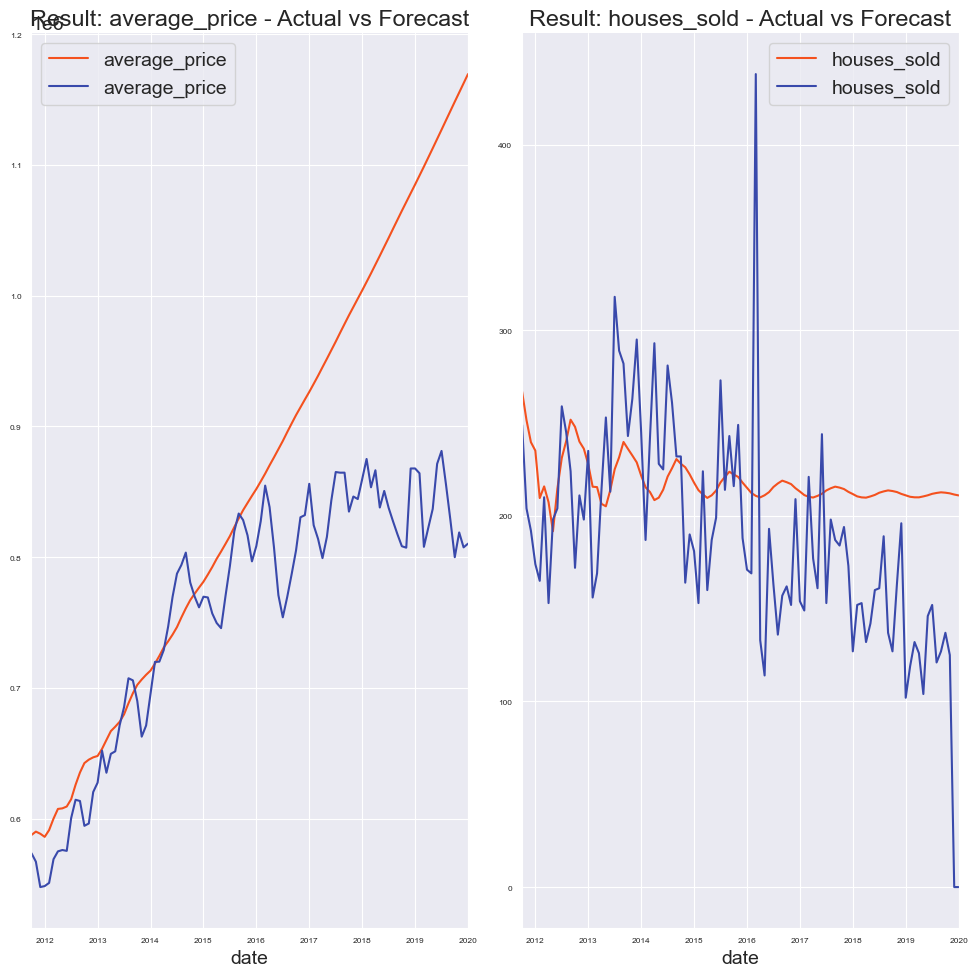

6473124415.888793


In [38]:
model = VAR(df_differenced)
results = model.fit(maxlags = 15, ic = 'aic')
results.summary()

# Forecasting for 100 steps ahead
lag_order = results.k_ar
predicted = results.forecast(df_differenced.values[-lag_order:], n_obs)
forecast = pd.DataFrame(predicted, index = df.index[-n_obs:], columns = df.columns)

# Plotting the Forecasted values
p1 = results.plot_forecast(1)
p1.tight_layout()

# Inverting the Differencing Transformation
def invert_transformation(df, df_forecast, second_diff=False):
    for col in df.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (df[col].iloc[-1] - df[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = df[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

forecast_values = invert_transformation(df_train, forecast, second_diff=True)

# ======================================   Visualization  ==========================================
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(df.columns)/2), ncols = 2, dpi = 100, figsize = (10,10))

for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    forecast_values[col].plot(color = '#F4511E', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    df_test[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Result: ' + col + ' - Actual vs Forecast')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

mse = mean_squared_error(df_test, forecast_values)
print(mse)

###### Analytics Vidhya

In [39]:
df.head()

average_price  houses_sold  no_of_crimes
date                                                
1995-01-01         120933       198.00          0.00
1995-02-01         119509       194.00          0.00
1995-03-01         120282       207.00          0.00
1995-04-01         120098       174.00          0.00
1995-05-01         119929       220.00          0.00

In [40]:
#creating the train and validation set
train = df[:int(0.8*(len(df)))]
valid = df[int(0.8*(len(df))):]

In [50]:
train.shape

(240, 3)

In [51]:
valid.shape

(61, 3)

In [41]:
model = VAR(endog=df_train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(df_test))

In [43]:
cols = df.columns

In [48]:
df.columns

Index(['average_price', 'houses_sold', 'no_of_crimes'], dtype='object')

In [47]:
#converting predictions to dataframe
from math import sqrt
pred = pd.DataFrame(index=range(0,len(prediction)), columns=[cols])
for j in range(0, 3):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

TypeError: only integer scalar arrays can be converted to a scalar index

In [52]:
#make final predictions
model = VAR(endog=data)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

###### TDS

https://towardsdatascience.com/multivariate-time-series-forecasting-653372b3db36

In [53]:
df.head()

average_price  houses_sold  no_of_crimes
date                                                
1995-01-01         120933       198.00          0.00
1995-02-01         119509       194.00          0.00
1995-03-01         120282       207.00          0.00
1995-04-01         120098       174.00          0.00
1995-05-01         119929       220.00          0.00

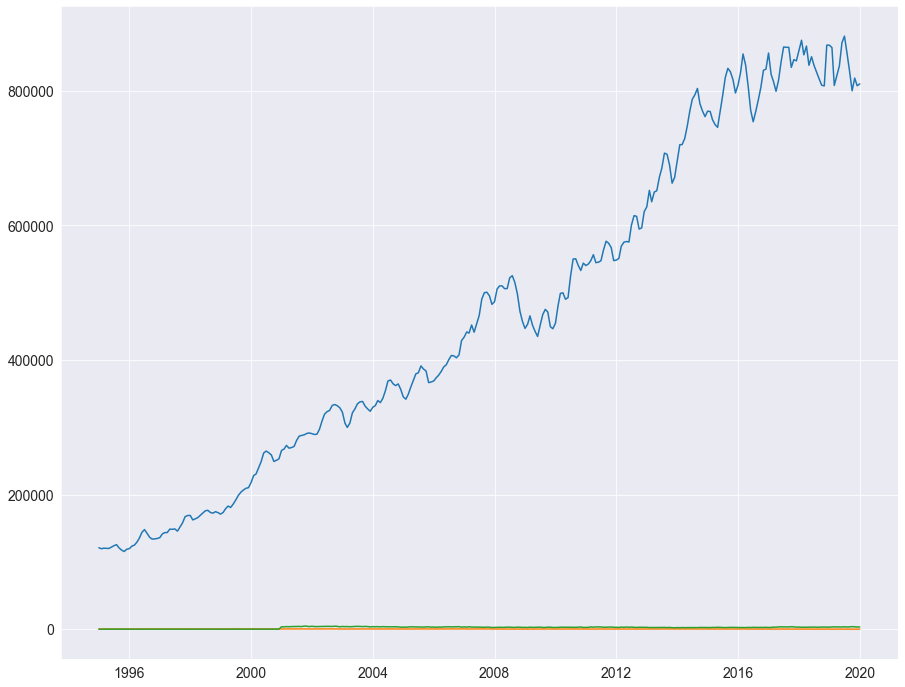

In [54]:
plt.plot(df)

In [63]:
# granger_test = sm.tsa.stattools.grangercausalitytests(df, maxlag=2, verbose=True)
# granger_test

In [64]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

In [65]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")
#apply adf test on the series
adf_test(df_train["average_price"])
adf_test(df_train["houses_sold"])
adf_test(df_train["no_of_crimes"])

Test Statistic          -0.29
p-value                  0.93
# Lags                  16.00
# Observations         280.00
Critical Value (1%)     -3.45
Critical Value (5%)     -2.87
Critical Value (10%)    -2.57
dtype: float64
 Series is Non-Stationary
Test Statistic          -2.05
p-value                  0.26
# Lags                  13.00
# Observations         283.00
Critical Value (1%)     -3.45
Critical Value (5%)     -2.87
Critical Value (10%)    -2.57
dtype: float64
 Series is Non-Stationary
Test Statistic          -2.17
p-value                  0.22
# Lags                  12.00
# Observations         284.00
Critical Value (1%)     -3.45
Critical Value (5%)     -2.87
Critical Value (10%)    -2.57
dtype: float64
 Series is Non-Stationary


In [66]:
# 1st difference
df_differenced = df_train.diff().dropna()
# stationarity test again with differenced data
adf_test(df_differenced["houses_sold"])

Test Statistic          -5.86
p-value                  0.00
# Lags                  11.00
# Observations         284.00
Critical Value (1%)     -3.45
Critical Value (5%)     -2.87
Critical Value (10%)    -2.57
dtype: float64
 Series is Stationary


In [67]:
model = VAR(df)
model_fit = model.fit()

In [68]:
# model fitting
model = VAR(df_differenced)
results = model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 31, May, 2021
Time:                     00:04:55
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    39.0090
Nobs:                     282.000    HQIC:                   38.0111
Log likelihood:          -6336.79    FPE:                1.66337e+16
AIC:                      37.3430    Det(Omega_mle):     1.08664e+16
--------------------------------------------------------------------
Results for equation average_price
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                  3018.912348       817.327664            3.694           0.000
L1.average_price          0.385218         0.065540            5.878           0.000
L1.houses_sold           24.789465  

In [69]:
pred = model_fit.forecast(model_fit.y, steps=1)
print(pred)

[[8.07670891e+05 4.98955217e+01 3.25386349e+03]]


In [70]:
# forecasting
lag_order = results.k_ar
results.forecast(df.values[-lag_order:], 5)

array([[-1.23404331e+05, -2.25597498e+03,  2.40897414e+03],
       [-5.31046450e+05, -1.26253032e+03,  3.72924830e+03],
       [-7.86091121e+05, -1.02838433e+03,  9.69659577e+02],
       [-2.54552940e+05, -8.34008544e+02,  3.43166279e+03],
       [ 2.03953096e+04, -6.98134045e+02,  2.48578328e+03]])

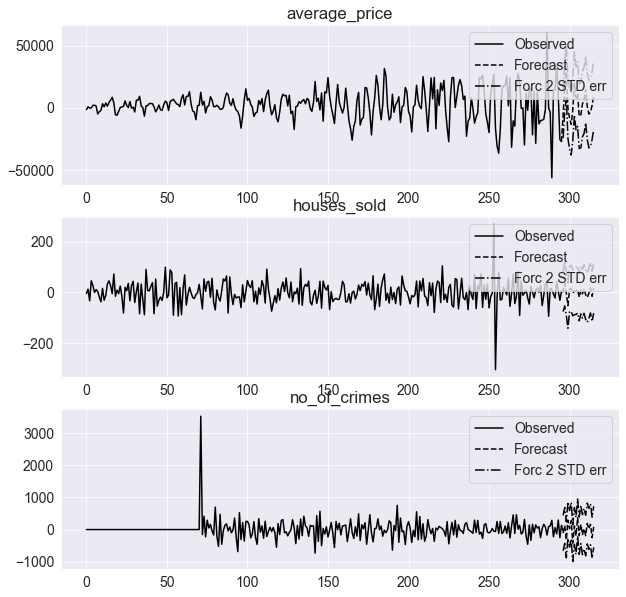

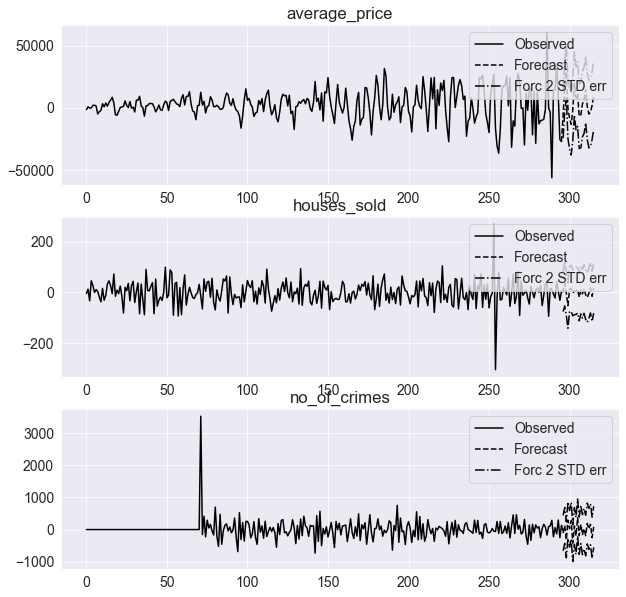

In [71]:
# plotting
results.plot_forecast(20)

In [72]:
# Evaluation
fevd = results.fevd(5)
fevd.summary()

FEVD for average_price
     average_price  houses_sold  no_of_crimes
0         1.000000     0.000000      0.000000
1         0.983443     0.008998      0.007559
2         0.984408     0.008472      0.007120
3         0.982052     0.011494      0.006454
4         0.981988     0.011755      0.006257

FEVD for houses_sold
     average_price  houses_sold  no_of_crimes
0         0.061599     0.938401      0.000000
1         0.052775     0.944556      0.002669
2         0.055687     0.940036      0.004277
3         0.061990     0.931294      0.006716
4         0.061694     0.930147      0.008159

FEVD for no_of_crimes
     average_price  houses_sold  no_of_crimes
0         0.000032     0.001349      0.998619
1         0.001293     0.001414      0.997293
2         0.005066     0.005821      0.989113
3         0.010344     0.006157      0.983499
4         0.012559     0.009113      0.978328




In [73]:
# forecasting
pred = results.forecast(results.y, steps=nobs)
df_forecast = pd.DataFrame(pred, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast.tail()
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
# show inverted results in a dataframe
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['average_price_forecast', 'houses_sold_forecast', 'no_of_crimes_forecast']]

average_price_forecast  houses_sold_forecast  \
date                                                       
2019-10-01              795,959.49                135.77   
2019-11-01              780,847.93                179.60   
2019-12-01              794,810.74                220.38   
2020-01-01              808,280.73                209.40   

            no_of_crimes_forecast  
date                               
2019-10-01               3,364.25  
2019-11-01               3,515.27  
2019-12-01               3,346.68  
2020-01-01               3,472.05

In [74]:
df.tail()

average_price  houses_sold  no_of_crimes
date                                                
2019-09-01         828560       127.00      3,342.00
2019-10-01         799950       137.00      3,736.00
2019-11-01         818880       125.00      3,447.00
2019-12-01         807466         0.00      3,191.00
2020-01-01         810298         0.00      3,214.00

In [78]:
df.shape

(301, 3)

In [79]:
df_results.shape

(4, 6)

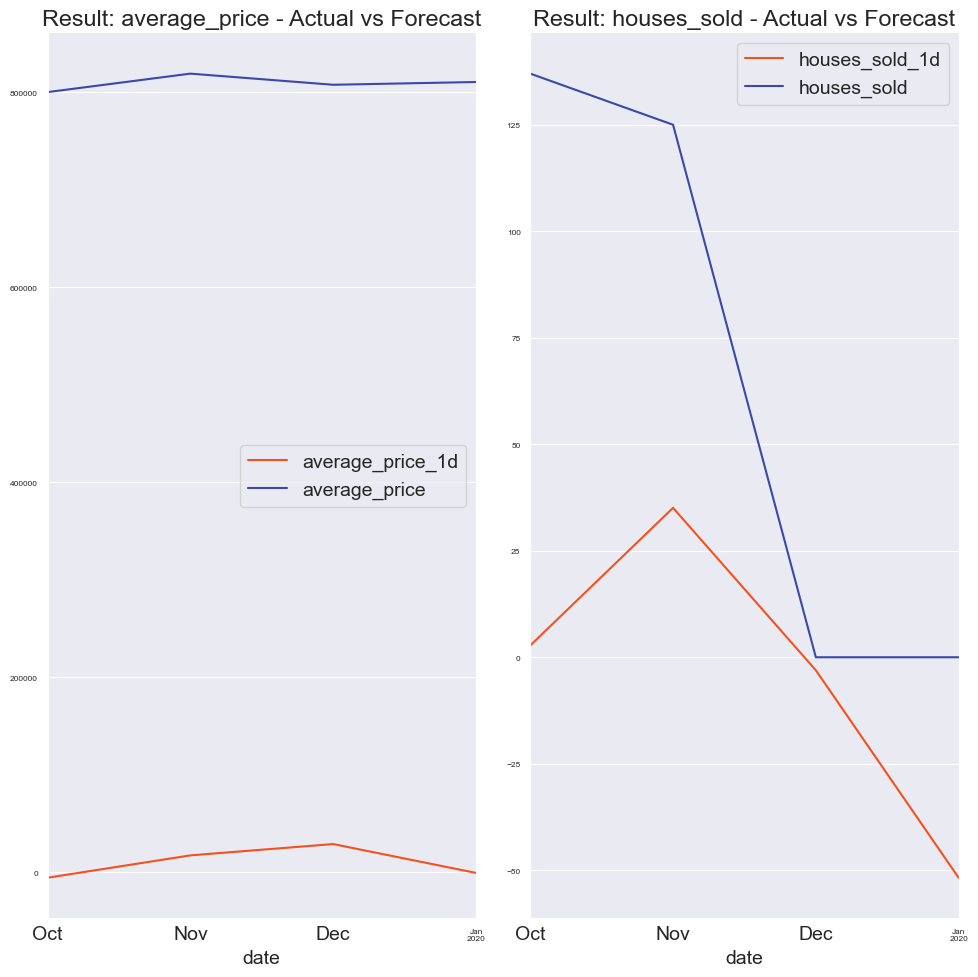

212850153684.10947


In [77]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(df.columns)/2), ncols = 2, dpi = 100, figsize = (10,10))

for i, (col, colx, ax) in enumerate(zip(df.columns, df_results.columns, axes.flatten())):
    df_forecast[colx].plot(color = '#F4511E', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    df_test[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Result: ' + col + ' - Actual vs Forecast')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

mse = mean_squared_error(df_test, df_forecast)
print(mse)

###### other references

https://www.kaggle.com/lokeshkumarn/timeseries-multivariate

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://www.statsmodels.org/stable/vector_ar.html#vector-ar--page-root

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.html

In [3]:
area = ['camden']

df_camden = data.loc[data['area'].isin(area)]

In [5]:
df_camden.head()

date    area  average_price       code  houses_sold  no_of_crimes  \
1806 1995-01-01  camden         120933  E09000007       198.00           nan   
1807 1995-02-01  camden         119509  E09000007       194.00           nan   
1808 1995-03-01  camden         120282  E09000007       207.00           nan   
1809 1995-04-01  camden         120098  E09000007       174.00           nan   
1810 1995-05-01  camden         119929  E09000007       220.00           nan   

      borough_flag  
1806             1  
1807             1  
1808             1  
1809             1  
1810             1

In [6]:
df_camden.shape

(301, 7)

In [7]:
display(df_camden.describe());

msno.matrix(df_camden);

average_price  houses_sold  no_of_crimes  borough_flag
count         301.00       299.00        229.00        301.00
mean      467,500.91       248.70      3,056.57          1.00
std       241,363.75        75.59        530.00          0.00
min       115,419.00        89.00      2,079.00          1.00
25%       269,837.00       191.00      2,611.00          1.00
50%       446,413.00       249.00      2,976.00          1.00
75%       689,918.00       302.00      3,414.00          1.00
max       881,212.00       446.00      4,558.00          1.00

In [8]:
# Set date as index for easier manipulation
df_camden = df_camden.set_index(pd.to_datetime(df_camden['date']))

In [9]:
df_camden.dropna()
# df_camden['no_of_crimes'] = df_camden['no_of_crimes'].fillna(0)
# df_camden['houses_sold'] = df_camden['houses_sold'].fillna(0)

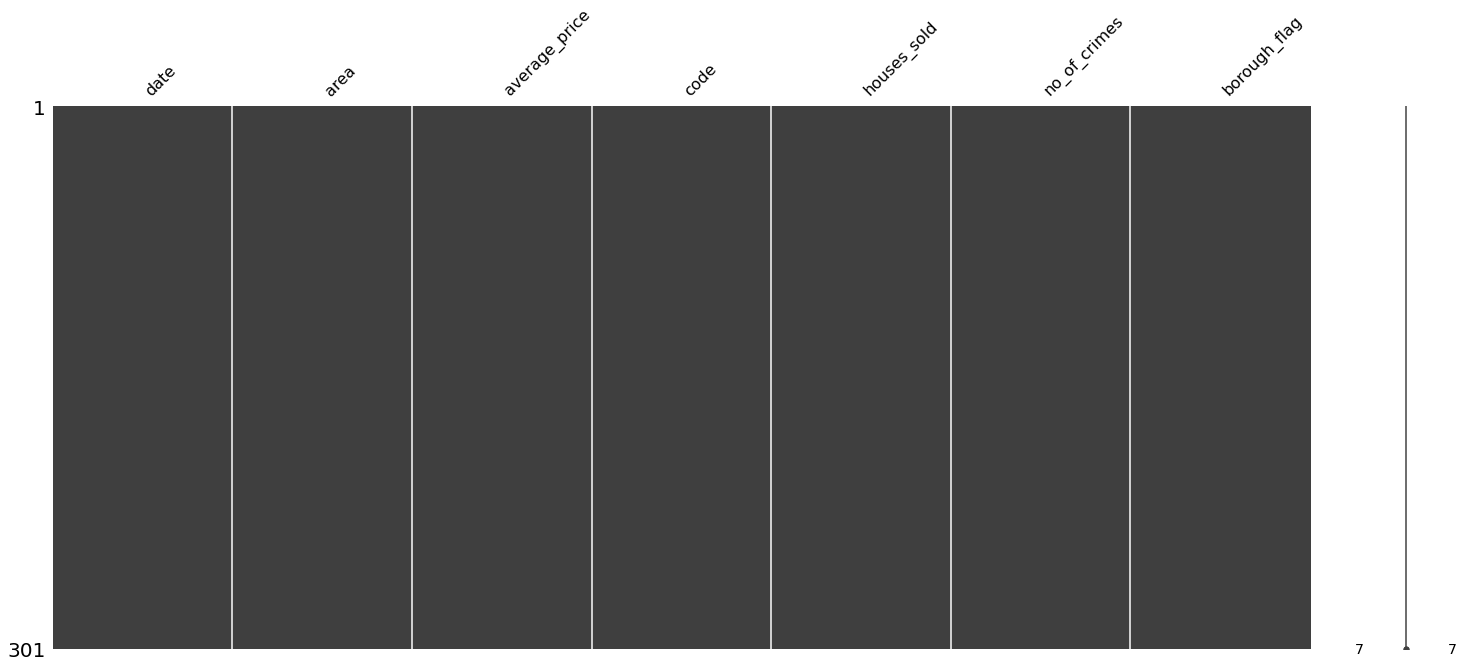

In [10]:
msno.matrix(df_camden);

In [12]:
df_camden.drop(['area', 'code', 'borough_flag'], axis = 1)
# df_camden.head()

date  average_price  houses_sold  no_of_crimes
date                                                           
1995-01-01 1995-01-01         120933       198.00          0.00
1995-02-01 1995-02-01         119509       194.00          0.00
1995-03-01 1995-03-01         120282       207.00          0.00
1995-04-01 1995-04-01         120098       174.00          0.00
1995-05-01 1995-05-01         119929       220.00          0.00
1995-06-01 1995-06-01         121887       248.00          0.00
1995-07-01 1995-07-01         124028       248.00          0.00
1995-08-01 1995-08-01         125530       259.00          0.00
1995-09-01 1995-09-01         120597       263.00          0.00
1995-10-01 1995-10-01         117458       245.00          0.00
1995-11-01 1995-11-01         115419       208.00          0.00
1995-12-01 1995-12-01         118739       224.00          0.00
1996-01-01 1996-01-01         119560       193.00          0.00
1996-02-01 1996-02-01         123371       181.00          0.00
1996-03-01 1996-03-01         124723       214.00          0.00
1996-04-01 1996-04-01         129159       260.00          0.00
1996-05-01 1996-05-01         135336       287.00          0.00
1996-06-01 1996-06-01         143862       282.00          0.00
1996-07-01 1996-07-01         147974       355.00          0.00
1996-08-01 1996-08-01         142462       340.00          0.00
1996-09-01 1996-09-01         136552       349.00          0.00
1996-10-01 1996-10-01         133850       344.00          0.00
1996-11-01 1996-11-01         134128       369.00          0.00
1996-12-01 1996-12-01         134749       354.00          0.00
1997-01-01 1997-01-01         135956       273.00          0.00
1997-02-01 1997-02-01         141531       293.00          0.00
1997-03-01 1997-03-01         143444       300.00          0.00
1997-04-01 1997-04-01         143592       336.00          0.00
1997-05-01 1997-05-01         148617       303.00          0.00
1997-06-01 1997-06-01         148336       330.00          0.00
1997-07-01 1997-07-01         148941       374.00          0.00
1997-08-01 1997-08-01         145623       334.00          0.00
1997-09-01 1997-09-01         151748       337.00          0.00
1997-10-01 1997-10-01         157898       374.00          0.00
1997-11-01 1997-11-01         167189       290.00          0.00
1997-12-01 1997-12-01         168839       323.00          0.00
1998-01-01 1998-01-01         169012       294.00          0.00
1998-02-01 1998-02-01         162345       206.00          0.00
1998-03-01 1998-03-01         163829       297.00          0.00
1998-04-01 1998-04-01         165652       305.00          0.00
1998-05-01 1998-05-01         169049       311.00          0.00
1998-06-01 1998-06-01         172582       335.00          0.00
1998-07-01 1998-07-01         175848       374.00          0.00
1998-08-01 1998-08-01         176576       290.00          0.00
1998-09-01 1998-09-01         173335       343.00          0.00
1998-10-01 1998-10-01         172385       289.00          0.00
1998-11-01 1998-11-01         174582       258.00          0.00
1998-12-01 1998-12-01         173072       240.00          0.00
1999-01-01 1999-01-01         170961       208.00          0.00
1999-02-01 1999-02-01         173480       210.00          0.00
1999-03-01 1999-03-01         178877       310.00          0.00
1999-04-01 1999-04-01         182926       289.00          0.00
1999-05-01 1999-05-01         180781       278.00          0.00
1999-06-01 1999-06-01         185845       367.00          0.00
1999-07-01 1999-07-01         191808       446.00          0.00
1999-08-01 1999-08-01         198650       356.00          0.00
1999-09-01 1999-09-01         203513       391.00          0.00
1999-10-01 1999-10-01         206707       431.00          0.00
1999-11-01 1999-11-01         209300       338.00          0.00
1999-12-01 1999-12-01         210240       357.00          0.00
2000-01-01 2000-01-01         217700       269.00

In [17]:
# del df_camden['date']
del df_camden['area']
del df_camden['code']
del df_camden['borough_flag']

In [18]:
df_camden.head()

average_price  houses_sold  no_of_crimes
date                                                
1995-01-01         120933       198.00          0.00
1995-02-01         119509       194.00          0.00
1995-03-01         120282       207.00          0.00
1995-04-01         120098       174.00          0.00
1995-05-01         119929       220.00          0.00

In [19]:
sns.set_style('darkgrid')
df_camden.plot(kind = 'line', legend = 'reverse', title = 'Visualizing Multivariate Time-Series')
# df_time_series.plot(kind = 'line', legend = 'reverse', title = 'Visualizing Multivariate Time-Series')
plt.legend(loc = 'upper right', shadow = True, bbox_to_anchor = (1.35, 0.8))
plt.show()

In [20]:
df = df_camden

In [21]:
# Splitting the dataset into train & test subsets
n_obs = 100
df_train, df_test = df[:-n_obs], df[-n_obs:]

def adf_test(df):
    dftest = adfuller(df, autolag='AIC')
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])

    for key, value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']
    if p <= 0.05:
        print("\nSeries is Stationary")
    else:
        print("\nSeries is Non-Stationary")


for i in df_train.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_train[i])
    print('\n')

# Differencing all variables to get rid of Stationarity
df_differenced = df_train.diff().dropna()

# Running the ADF test once again to test for Stationarity
for i in df_differenced.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_differenced[i])
    print('\n')

# Now cols: 3, 5, 6, 8 are non-stationary
df_differenced = df_differenced.diff().dropna()

# Running the ADF test for the 3rd time to test for Stationarity
for i in df_differenced.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_differenced[i])
    print('\n')

Column:  average_price
--------------------------------------
Test Statistic          -0.01
p-value                  0.96
# Lags                  15.00
# Observations         185.00
Critical Value (1%)     -3.47
Critical Value (5%)     -2.88
Critical Value (10%)    -2.58
dtype: float64

Series is Non-Stationary


Column:  houses_sold
--------------------------------------
Test Statistic          -2.72
p-value                  0.07
# Lags                  12.00
# Observations         188.00
Critical Value (1%)     -3.47
Critical Value (5%)     -2.88
Critical Value (10%)    -2.58
dtype: float64

Series is Non-Stationary


Column:  no_of_crimes
--------------------------------------
Test Statistic          -1.77
p-value                  0.40
# Lags                  12.00
# Observations         188.00
Critical Value (1%)     -3.47
Critical Value (5%)     -2.88
Critical Value (10%)    -2.58
dtype: float64

Series is Non-Stationary


Column:  average_price
-----------------------------------

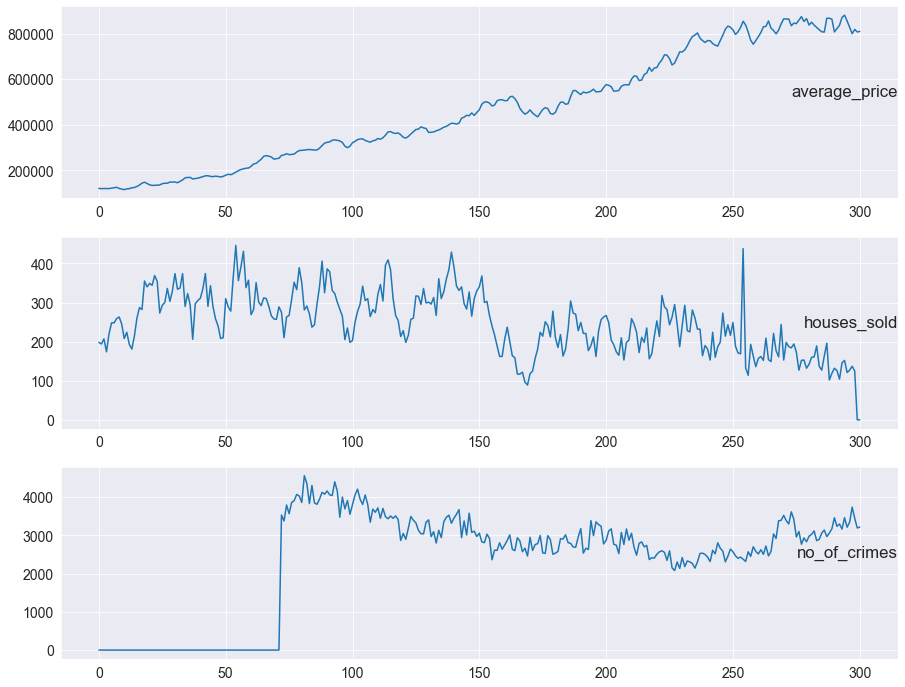

In [23]:
values = df.values
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

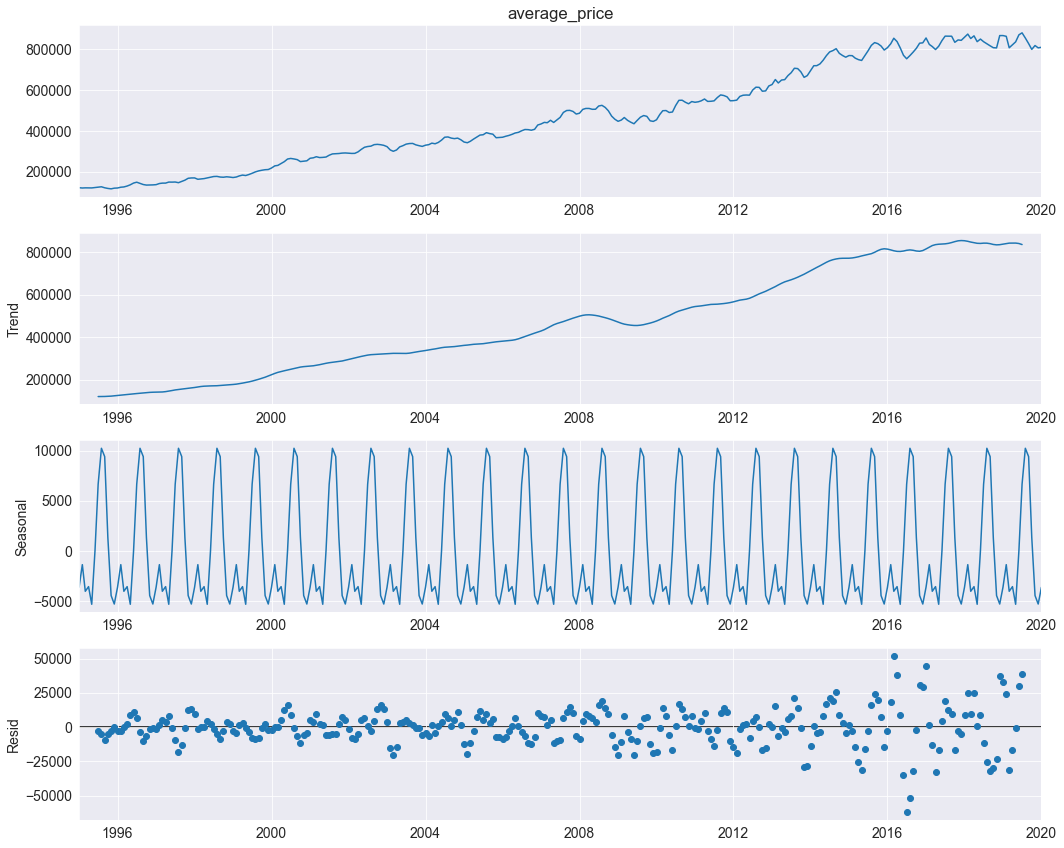

In [25]:
decomposition = sm.tsa.seasonal_decompose(df['average_price'], model='additive')
fig = decomposition.plot()
plt.show()